# Notebook14 b) Combined Aspect Sentiment Model - Multi-class

This notebook brings together the best aspect models and the best sentiment model into one function, able to take in single raw reviews. This includes:

* 3 multi-class aspect models
* a binary sentiment model

Current sample reviews taken from TripAdvisor for each category are used to test the model.

* Section 1 - Import libraries
* Section 2 - Import data and models
* Section 3 - Functions
* Section 4 - Testing the model



Note:Notebook 14 b) repeats this model but takes account of neutral reviews. The results of Notebooks 14 a) and 14 b) are compared by using sample reviews of each category and assessing how well each performs. The best model is then run with another sample of raw text reviews and results examined in Notebook 15.

# Section 1: Import libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.svm import LinearSVC
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.utils import class_weight
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Dropout
import contractions
import pickle
import joblib
import string
import ast
import os
from spellchecker import SpellChecker
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
from pandas import option_context

# Section 2: Import data and models

### Import Test data

In [6]:
def open_tok(name):
    with open(name, 'rb') as handle:
        file = pickle.load(handle)
        return file

### Import Tokenizers

In [7]:
# Tokenzier objects (all are TFIDF tokenizers except food which is Keras tokenizer object)
accom_tok = open_tok("accom_tok.pickle")
food_tok = open_tok("food_tokenizer.pickle")
attract_tok = open_tok("attract_tok.pickle")
sent_tok = open_tok('tok_sent_multiclass.pickle')

### Import Models

In [22]:
# Aspect models (Accom - ML Model SVM TFIDF, Food - Neural Network Model, Attract = ML Model SVM TFIDF)
model1 = joblib.load('best_model_accom.sav')
model2 = load_model('best_model_food.h5')
model3 = load_model('best_model_attract.h5')

# Multiclass Sentiment model 
model4 = load_model("SentimentMultiNeural.h5")

# Section 3: Functions

### Function 1 - Text Processing

In [9]:
# Function to clean sentences

def process(text):
    if text != []:
        text = text.replace('\n',' ')
        text = text.strip().lower()
        text = text.replace('xmas','christmas')
        text = text.replace('\£',"") 
        text = text.replace(r'\/'," ") 
        text = text.replace('\d+\-\d+',"") 
        text = text.replace('\d+\w{2}',"") 
        text = text.replace('\.{3,}',"") 
        text = text.replace(' i ',"")
        text = text.replace(' le ',"")
        text = contractions.fix(text)
        text = nltk.word_tokenize(text)
        punc = string.punctuation
        text = [word for word in text if word not in punc]
        text = [n for n in text if not n.isnumeric()]
        text = [e for e in text if e.encode("ascii","ignore")]
        stop = stopwords.words("english")
        stop_remove = ["not","don't","didn't","wasn't","won't","isn't"]
        stop1 = [w for w in stop if w not in stop_remove]
        add_stop = ['etc','read','read less','lot','butlins', 'bognor','regis','b',' i ','..','arundel castle','premier','inn','u',
                    'castle',"year","hilton","time","day","shoreline","oyster","bay","church farm","hotham","hotham park",
                    "hawk walk","hawk","arundel","littlehampton"]
        stop1.extend(add_stop)
        text = [w for w in text if w not in stop1]
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(w) for w in text ]
        spell = SpellChecker()
        word_list = []
        for w in text:
            new = spell.correction(w)
            if new != w:
                word_list.append(new)
            else:
                word_list.append(w)
            text = ' '.join(word_list) 
            
                       
    return text

### Function 2 - Construct Dataframe

In [202]:
def construct(review):
    sentences = pd.DataFrame(nltk.sent_tokenize(review),columns = ["Sentences"])
    sentences["cleaned"] = sentences["Sentences"].apply(lambda x: process(x))
    sentences["extract_noun_phrases"] = sentences["cleaned"].apply(phrase_extract)
    sentences['extract_noun_phrases'] = np.where(sentences['extract_noun_phrases'].str.len() == 0, 
                                                 sentences['cleaned'], sentences['extract_noun_phrases'])
    sentences["joined_phrases"] = sentences["extract_noun_phrases"].apply(lambda x: ' '.join(x) if type(x) != str else x)
    sentences["extract_nouns"] = sentences["cleaned"].apply(extract)
    sentences["joined_nouns"] = sentences["extract_nouns"].apply(lambda x: ' '.join(x))
    sentences["joined_nouns"] = sentences["joined_nouns"].apply(lambda x: "general" if x == "" else x)
    return sentences

### Function 3 - Aspect Extraction

In [10]:
def extract(text):
    text = word_tokenize(text)
    text_pos = nltk.tag.pos_tag(text)
    noun = [i[0] for i in text_pos if i[1].startswith('N')]
    return noun

### Function 4 - Noun Phrase Extraction

In [11]:
# Create function to extract noun phrases from a review using TextBlob
def phrase_extract(text):
    blob = TextBlob(text)
    return blob.noun_phrases

### Function 5 - Encoding text 

In [12]:
# To padded sequences for the food aspects
def encode(nouns,tokenizer):
    x_s = tokenizer.texts_to_sequences(nouns)
    x_w = pad_sequences(np.array(x_s, dtype = "object"), maxlen = 20,padding = "post", truncating = "post", value = 0.0)
    return x_w

In [13]:
# To TFIDF vectorizer for all other category aspects and sentiment
def encode2(text,vectorizer):
    enc = vectorizer.transform(text)
    return enc

### Function 6 - Prediction

In [14]:
# Machine learning model
def predict1(model,X):
    y_pred = model.predict(X)
    return y_pred

### Function 7 - Sentiment

In [35]:
def sent(text):
    label_sent = {0:"Negative",1:"Neutral",2:"Positive"}
    ss = sent_tok.texts_to_sequences(text)
    ws = pad_sequences(np.array(ss, dtype = "object"), maxlen = 20,padding = "post", truncating = "post", value = 0.0)
    sent_predict = pd.DataFrame(predict1(model4, ws))
    y_sent_pred = pd.DataFrame(np.argmax(model4.predict(ws), axis=-1),columns = ["S"])
    y_sent_pred["Sentiment"] = y_sent_pred["S"].apply(lambda x: label_sent.get(x))
    return y_sent_pred


### Function 8 - Scoring

In [187]:
def scoring(x):
    if x == "Positive":
        score = 1
    elif x == "Negative":
        score = -1
    else:
        score = 0
    return score

### Function 9 - Chart

In [287]:
def display_chart(df):
    summary = df.groupby(["Predicted Aspect","Score"],as_index = False)["Sentiment"].count()
    summary['positive'] = summary['Score'] > 0
    labels = summary["Predicted Aspect"]
    a = summary["Score"]
    fig, ax = plt.subplots(figsize = (6,5))
    ax.bar(labels, a,color = summary.positive.map({True: 'lightsteelblue', False: 'slategrey'}))
    ax.set_title("Number of Positive and Negative Comments About Aspects",pad = 25,fontsize = 15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom = False)
    ax.locator_params(axis="y", integer=True)
    plt.show()

### Function 10 - Combined

In [288]:
# Run initial function
def review_analyser(review,category):
    
    # Labels
    label_accom = {0:'Entertainment',1:'Food',2:'Hotel',3:'Location',4:'Room',5:'Staff',6:'Value'}
    label_food = {0:"Food Quality",1:"Meal Exp",2:"Menu Choice",3:"Staff",4:"Value",5:"Visit Exp"}
    label_attract = {0:"Activities",1:"Amenities",2:"History",3:"Nature",4:"Staff/Service",5:"Value",6:"Visit Exp"}
    
    # Models with weights
    accom = model1
    food = model2
    attract = model3
    sentiment = model4
    
    # Split review into sentences, extract noun_phrases and nouns and clean. Where extracted noun_phrases is an empty list
    # the cleaned column is inserted instead.
    sentences = construct(review)
    
    # Predict aspects and sentiment for food
    if category == "food":
        s = food_tok.texts_to_sequences(sentences["joined_nouns"])
        w = pad_sequences(np.array(s, dtype = "object"), maxlen = 100,padding = "post", truncating = "post", value = 0.0)
        predict = predict1(model2,w)
        y_pred_class = np.argmax(model2.predict(w), axis=-1)
        y_pred_class = pd.DataFrame(y_pred_class, columns = ["A"])
        y_pred_class["Predicted Aspect"] = y_pred_class["A"].apply(lambda x: label_food.get(x))
        
        y_sent_pred = sent(sentences["joined_phrases"])
        sentiment_summary = pd.concat([sentences["Sentences"],y_sent_pred],axis = 1) 
                         
    # Predict aspects and sentiment for accommodation
    elif category == "accommodation":
        encoded = accom_tok.transform(sentences["joined_nouns"])
        predict = predict1(model1,encoded)  
        y_pred_class = pd.DataFrame(predict, columns = ["A"])
        y_pred_class["Predicted Aspect"] = y_pred_class["A"].apply(lambda x: label_accom.get(x))
        
        y_sent_pred = sent(sentences["joined_phrases"])
        sentiment_summary = pd.concat([sentences["Sentences"],y_sent_pred],axis = 1) 
        
           
    # Predict aspects and sentiment for attractions
    else:
        s = attract_tok.texts_to_sequences(sentences["joined_nouns"])
        w = pad_sequences(np.array(s, dtype = "object"), maxlen = 100,padding = "post", truncating = "post", value = 0.0)
        predict = predict1(model3,w)
        y_pred_class = np.argmax(model3.predict(w), axis=-1)
        y_pred_class = pd.DataFrame(y_pred_class, columns = ["A"])
        y_pred_class["Predicted Aspect"] = y_pred_class["A"].apply(lambda x: label_attract.get(x)) 
        
        y_sent_pred = sent(sentences["joined_phrases"])
        sentiment_summary = pd.concat([sentences["Sentences"],y_sent_pred],axis = 1) 
               
    aspect_sentiment = pd.concat([y_pred_class,sentiment_summary],axis = 1)
    display(aspect_sentiment)
    aspect_sentiment["Score"] = aspect_sentiment["Sentiment"].apply(lambda x: scoring(x))
    pos_neg = aspect_sentiment[aspect_sentiment["Sentiment"] != "Neutral"]
    display_chart(pos_neg)
           
   # with option_context('display.max_colwidth', 100):
       # display(aspect_sentiment)
              
    return aspect_sentiment

# Section 4: Testing the Function

## Sample reviews

In [209]:
# Food Review
review_test = "Went for a birthday celebration they fail to tell you when you book that they no longer serve alcohol even though we have been long term customers. It was suggested we go to a nearby supermarket and purchase our own alcohol, not really ideal on a night out. Prices have gone up massively maybe to compensate for not selling alcohol anymore. Would not recommend, we left and found Magna Indian restaurant which was reasonable accommodating and lovely food"
print(review_test)

Went for a birthday celebration they fail to tell you when you book that they no longer serve alcohol even though we have been long term customers. It was suggested we go to a nearby supermarket and purchase our own alcohol, not really ideal on a night out. Prices have gone up massively maybe to compensate for not selling alcohol anymore. Would not recommend, we left and found Magna Indian restaurant which was reasonable accommodating and lovely food


,A,Predicted Aspect,Sentences,S,Sentiment
0,2,Menu Choice,Went for a birthday celebration they fail to t...,0,Negative
1,5,Visit Exp,It was suggested we go to a nearby supermarket...,1,Neutral
2,4,Value,Prices have gone up massively maybe to compens...,0,Negative
3,0,Food Quality,"Would not recommend, we left and found Magna I...",1,Neutral


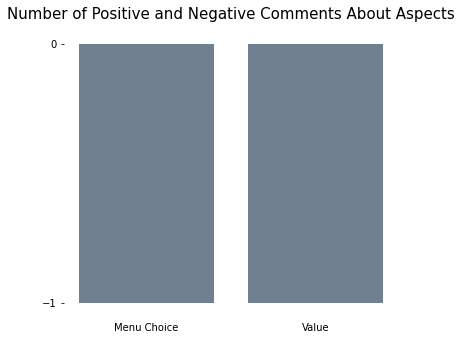

,A,Predicted Aspect,Sentences,S,Sentiment,Score
0,2,Menu Choice,Went for a birthday celebration they fail to t...,0,Negative,-1
1,5,Visit Exp,It was suggested we go to a nearby supermarket...,1,Neutral,0
2,4,Value,Prices have gone up massively maybe to compens...,0,Negative,-1
3,0,Food Quality,"Would not recommend, we left and found Magna I...",1,Neutral,0


In [292]:
review_analyser(review_test,"food")

In [211]:
# Accommodation Review
review_test1 = "Room absolutely stunk of cigarettes. Avoid. Nowhere to eat locally either. Tried restaurant but told had to wait 2 hours for table despite no one sitting outside on a sunny day and only 2 people that I could see inside.Asked reception and told restaurant 15 min walk away (it wasnt) but may hv to book. No offer phone up to see if table free!"
print(review_test1)

Room absolutely stunk of cigarettes. Avoid. Nowhere to eat locally either. Tried restaurant but told had to wait 2 hours for table despite no one sitting outside on a sunny day and only 2 people that I could see inside.Asked reception and told restaurant 15 min walk away (it wasnt) but may hv to book. No offer phone up to see if table free!


,A,Predicted Aspect,Sentences,S,Sentiment
0,4,Room,Room absolutely stunk of cigarettes.,1,Neutral
1,0,Entertainment,Avoid.,1,Neutral
2,4,Room,Nowhere to eat locally either.,1,Neutral
3,1,Food,Tried restaurant but told had to wait 2 hours ...,0,Negative
4,0,Entertainment,No offer phone up to see if table free!,2,Positive


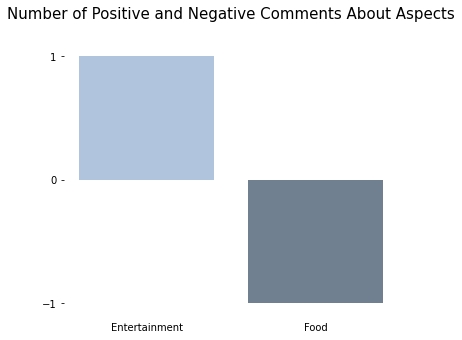

,A,Predicted Aspect,Sentences,S,Sentiment,Score
0,4,Room,Room absolutely stunk of cigarettes.,1,Neutral,0
1,0,Entertainment,Avoid.,1,Neutral,0
2,4,Room,Nowhere to eat locally either.,1,Neutral,0
3,1,Food,Tried restaurant but told had to wait 2 hours ...,0,Negative,-1
4,0,Entertainment,No offer phone up to see if table free!,2,Positive,1


In [291]:
review_analyser(review_test1,"accommodation")

In [217]:
# Attraction Review
review_test2 = "On the outskirts of Bognor this park is very pleasant with a large cafe and an excellent crazy golf course. It also has a miniature railway and a boating lake but both were closed on the afternoon of our visit. However, we walked around the main pathways and saw a few squirrels. A very pleasant place for a short visit."
print(review_test2)

On the outskirts of Bognor this park is very pleasant with a large cafe and an excellent crazy golf course. It also has a miniature railway and a boating lake but both were closed on the afternoon of our visit. However, we walked around the main pathways and saw a few squirrels. A very pleasant place for a short visit.


,A,Predicted Aspect,Sentences,S,Sentiment
0,6,Visit Exp,On the outskirts of Bognor this park is very p...,2,Positive
1,3,Nature,It also has a miniature railway and a boating ...,2,Positive
2,6,Visit Exp,"However, we walked around the main pathways an...",1,Neutral
3,4,Staff/Service,A very pleasant place for a short visit.,0,Negative


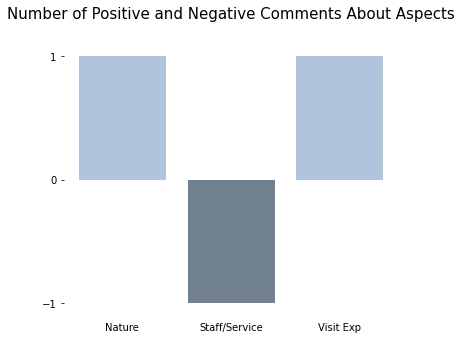

,A,Predicted Aspect,Sentences,S,Sentiment,Score
0,6,Visit Exp,On the outskirts of Bognor this park is very p...,2,Positive,1
1,3,Nature,It also has a miniature railway and a boating ...,2,Positive,1
2,6,Visit Exp,"However, we walked around the main pathways an...",1,Neutral,0
3,4,Staff/Service,A very pleasant place for a short visit.,0,Negative,-1


In [293]:
review_analyser(review_test2,"attractions")

# Section 5: Taking in more than one review

In [ ]:
for review in df:
    df_all_results = pd.DataFrame()
    result = review_analyser(review,df["Category"])
    df_all_results.append(result)

In [44]:
df_new_reviews = pd.read_csv("NEWACCOMREVIEWS.csv")
df_new_reviews

,Column1
0,This time we went for basic accommodation opti...
1,Having spent many happy family holidays here i...
2,We booked last minute and paid under £500 Inst...
3,Just wanted to give my review. !!!!After readi...
4,Just got back from our stay at Butlin’s Bognor...
